In [8]:
%load_ext autoreload
%autoreload 2

from text3d2video.artifacts.attn_features_artifact import AttentionFeaturesArtifact
from math import sqrt
from torch import Tensor
from omegaconf import OmegaConf

from text3d2video.attention_visualization import (
    concatenate_images,
    coord_to_pixel,
    pixel_coord_flattened,
    plot_qry_value_weights,
    reshape_concatenated,
    plot_image_and_weight
)
import matplotlib.pyplot as plt


artifact_tag = "attn_data:latest"
attn_data = AttentionFeaturesArtifact.from_wandb_artifact_tag(
    artifact_tag
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# get run data
run = attn_data.logged_by()
conf = OmegaConf.create(run.config)

target_frame_indices = list(conf.cross_frame_attn_experiment.target_frame_indices)

In [1]:
# read attn data
from dataclasses import dataclass

from text3d2video.attention_visualization import split_heads

multidict = attn_data.get_features_diskdict()
images = attn_data.get_images()
layer_names = sorted(multidict.key_values("layer"))
time_steps = sorted(multidict.key_values("timestep"))

dec_layers = [layer for layer in layer_names if "up_blocks" in layer]
enc_layers = [layer for layer in layer_names if "down_blocks" in layer]

@dataclass
class AttnFeatures:
    qrys_mh: Tensor
    keys_mh: Tensor
    vals_mh: Tensor
    layer_res: int

def get_attn_features(layer, time_step):
    identifier = {"layer": layer, "timestep": time_step}

    # get queries keys and values
    qrys = multidict[identifier | {"name": "query"}][: len(images)]
    keys = multidict[identifier | {"name": "key"}][: len(images)]
    vals = multidict[identifier | {"name": "value"}][: len(images)]

    qrys_mh = split_heads(qrys)
    keys_mh = split_heads(keys)
    vals_mh = split_heads(vals)

    return AttnFeatures(qrys_mh, keys_mh, vals_mh, int(sqrt(qrys.shape[1])))

NameError: name 'attn_data' is not defined

/home/jorge/thesis/text3d2video/disk_multidict.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return self.deserialization_fun(path)


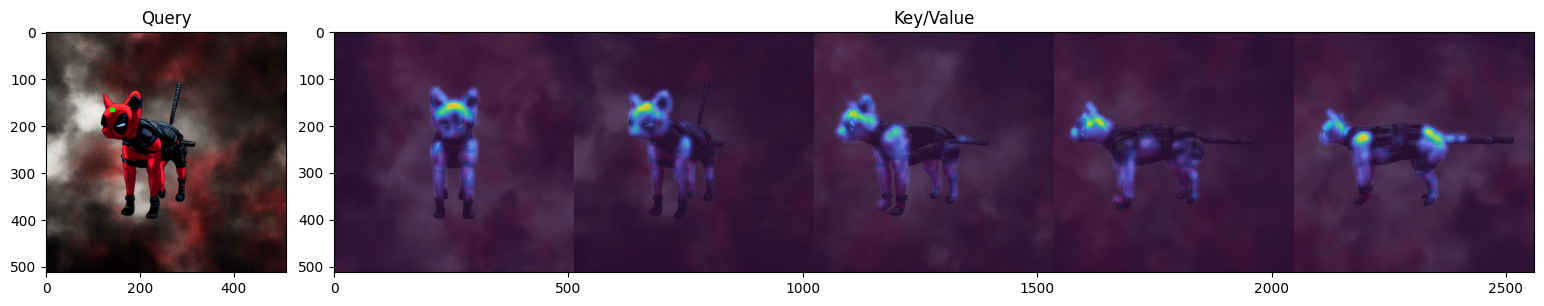

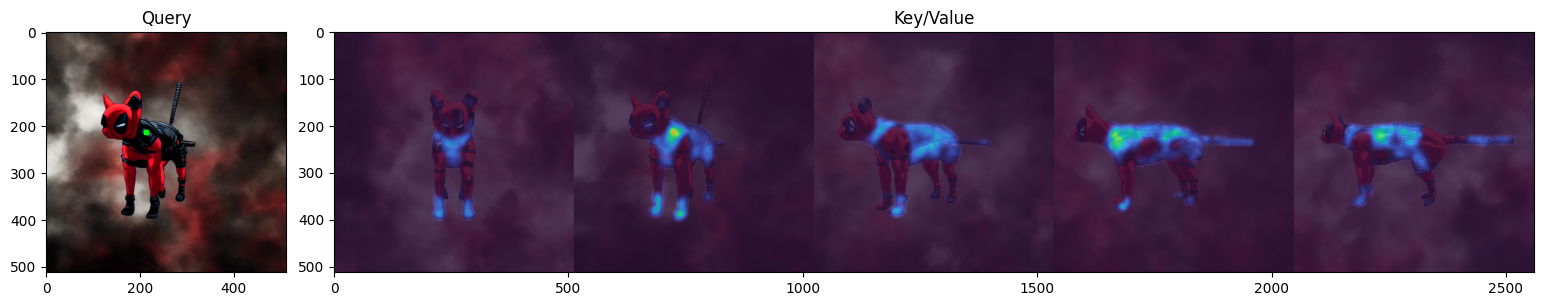

In [5]:
from text3d2video.attention_utils import compute_attn_weights

def plot_qry_weights(layer, time_step, qry_coord, frame_idx=0, head_idx=0):
    attn_features = get_attn_features(layer, time_step)
    layer_res = attn_features.layer_res

    keys = attn_features.keys_mh[:, :, head_idx, :]
    qrys = attn_features.qrys_mh[:, :, head_idx, :]

    # compute attn weights
    attn_weights = compute_attn_weights(qrys, keys)

    # get the index in attn weights corresponding to the query
    qry_size = (layer_res, layer_res)
    qry_pix = coord_to_pixel(qry_coord, qry_size)
    qry_pix_1d = pixel_coord_flattened(qry_pix, qry_size)

    # get weights for query, and reshape to square
    weights = attn_weights[frame_idx, qry_pix_1d, :]
    weights = reshape_concatenated(weights.unsqueeze(-1), layer_res=layer_res)[0]

    # get query and val images
    qry_im = images[frame_idx]
    val_im = concatenate_images(images)

    # plot
    plot_qry_value_weights(
        qry_im,
        val_im,
        qry_coord=qry_coord,
        kv_weights=weights,
        weights_alpha=0.8,
        weights_interpolation="bicubic",
        layer_res=layer_res,
    )

frame_idx = 1
head_idx = 1
time_step = time_steps[2]
coord_red = Tensor([0.28, 0.32])
coord_black = Tensor([0.41, 0.42])
layer = dec_layers[-1]

plot_qry_weights(layer, time_step, coord_red, frame_idx=frame_idx, head_idx=head_idx)
plot_qry_weights(layer, time_step, coord_black, frame_idx=frame_idx, head_idx=head_idx)

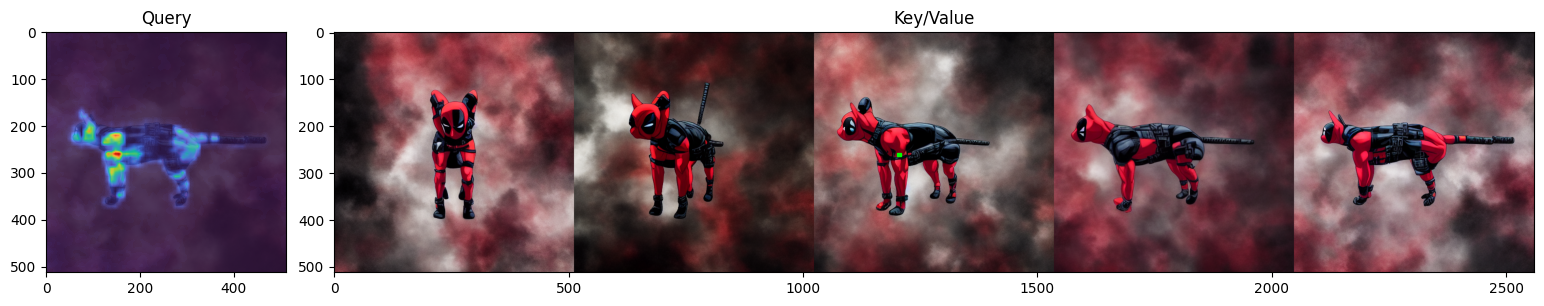

In [12]:
def plot_val_weights(layer, time_step, kv_coord, frame_idx=0, head_idx=0):
    attn_features = get_attn_features(layer, time_step)
    layer_res = attn_features.layer_res

    keys = attn_features.keys_mh[:, :, head_idx, :]
    qrys = attn_features.qrys_mh[:, :, head_idx, :]

    # compute attn weights
    attn_weights = compute_attn_weights(qrys, keys)

    # get the index in attn weights corresponding to the value
    kv_size = (layer_res*5,  layer_res)
    kv_pix = coord_to_pixel(kv_coord, kv_size)
    kv_pix_1d = pixel_coord_flattened(kv_pix, kv_size)

    # get weights for value, and reshape to square
    weights = attn_weights[frame_idx, :, kv_pix_1d]
    weights = reshape_concatenated(weights.unsqueeze(-1), layer_res=layer_res)[0]

    # get query and val images
    qry_im = images[frame_idx]
    val_im = concatenate_images(images)

    # plot
    plot_qry_value_weights(
        qry_im,
        val_im,
        val_coord=kv_coord,
        qry_weights=weights,
        weights_alpha=0.8,
        weights_interpolation="bilinear",
    )

frame_idx = 4
head_idx = 3
time_step = time_steps[-2]
layer = dec_layers[-1]
coord_red = Tensor([0.47, 0.5])

plot_val_weights(layer, time_step, coord_red, frame_idx=frame_idx, head_idx=head_idx)

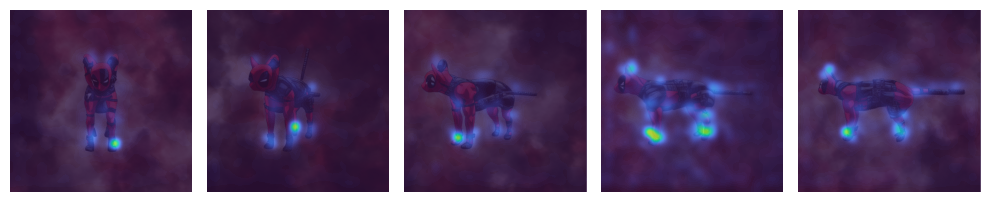

In [11]:
def plot_val_weights(layer, time_step, kv_coord, frame_indices=[], head_idx=0):
    attn_features = get_attn_features(layer, time_step)
    layer_res = attn_features.layer_res

    keys = attn_features.keys_mh[:, :, head_idx, :]
    qrys = attn_features.qrys_mh[:, :, head_idx, :]

    # compute attn weights
    attn_weights = compute_attn_weights(qrys, keys)

    # get the index in attn weights corresponding to the value
    kv_size = (layer_res*5,  layer_res)
    kv_pix = coord_to_pixel(kv_coord, kv_size)
    kv_pix_1d = pixel_coord_flattened(kv_pix, kv_size)
        
    fig, axs = plt.subplots(1, len(frame_indices), figsize=(10, 5))

    for i, frame_idx in enumerate(frame_indices):

        # get weights for value, and reshape to square
        weights = attn_weights[frame_idx, :, kv_pix_1d]
        weights = reshape_concatenated(weights.unsqueeze(-1), layer_res=layer_res)[0]

        ax = axs[i]
        ax.axis('off')

        qry_im = images[frame_idx]
        plot_image_and_weight(ax, qry_im, weights, interpolation="bicubic")

    plt.tight_layout()

head_idx = 3
time_step = time_steps[0]
layer = dec_layers[4]
frame_indices = [0,1,2,3,4]
coord_red = Tensor([0.5, 0.5])

plot_val_weights(layer, time_step, coord_red, frame_indices=frame_indices, head_idx=head_idx)